# Getting confident with Spark distributed file storage

Before we start Spark and the analysis of big data, we will look to 3 databricks useful concepts. The filesystem, the display method and the built in SQL commands. 

The concept of big data is tightly coupled with concepts like datalake and the hadoop ecosystem.  
Frequently in tutorials, spark will use hadoop as the underlying platform (before diving in spark we will look into the distributed file system backing it up).    

[What are the differences to hdfs?](https://stackoverflow.com/questions/55386728/what-are-the-main-differences-between-hdfs-and-databricks-dbfs)  
[Some _biased_ opinions on the advantages of dbfs over hdfs](https://databricks.com/blog/2017/05/31/top-5-reasons-for-choosing-s3-over-hdfs.html)

What is [Amazon’s S3, Microsoft’s Azure Blob Storage, Google’s Cloud Storage, insert your favourite cloud provider name here]?  
They are [object storage systems](https://en.wikipedia.org/wiki/Object_storage) summarized as a filesystems over the network. 

Databricks uses as a default distributed storage the [dbfs](https://docs.databricks.com/data/databricks-file-system.html), let's take some time to understand how to operate with it.

## Databricks File System (DBFS)

Here we will see some examples of how to interact with the dbfs.

In [0]:
dbutils.fs.help()

dbutils.fs provides utilities for working with FileSystems. Most methods in
this package can take either a DBFS path (e.g., "/foo" or "dbfs:/foo"), or
another FileSystem URI.

For more info about a method, use dbutils.fs.help("methodName") .

In notebooks, you can also use the %fs shorthand to access DBFS. The %fs shorthand maps
straightforwardly onto dbutils calls. For example, "%fs head --maxBytes=10000 /file/path"
translates into "dbutils.fs.head("/file/path", maxBytes = 10000)".
 fsutils cp(from: String, to: String, recurse: boolean = false): boolean -> Copies a file or directory, possibly across FileSystems head(file: String, maxBytes: int = 65536): String -> Returns up to the first 'maxBytes' bytes of the given file as a String encoded in UTF-8 ls(dir: String): Seq -> Lists the contents of a directory mkdirs(dir: String): boolean -> Creates the given directory if it does not exist, also creating any necessary parent directories mv(from: String, to: String, recurse: boolean = false): boolean -> Moves a file or directory, possibly across FileSystems put(file: String, contents: String, overwrite: boolean = false): boolean -> Writes the given String out to a file, encoded in UTF-8 rm(dir: String, recurse: boolean = false): boolean -> Removes a file or directory mount mount(source: String, mountPoint: String, encryptionType: String = "", owner: String = null, extraConfigs: Map = Map.empty[String, String]): boolean -> Mounts the given source directory into DBFS at the given mount point mounts: Seq -> Displays information about what is mounted within DBFS refreshMounts: boolean -> Forces all machines in this cluster to refresh their mount cache, ensuring they receive the most recent information unmount(mountPoint: String): boolean -> Deletes a DBFS mount point updateMount(source: String, mountPoint: String, encryptionType: String = "", owner: String = null, extraConfigs: Map = Map.empty[String, String]): boolean -> Similar to mount(), but updates an existing mount point (if present) instead of creating a new one

Let's use the **put** method to try and add files to the file storage

In [0]:
dbutils.fs.put("dataframe_sample.csv", """id|end_date|start_date|location
1|2015-10-14 00:00:00|2015-09-14 00:00:00|CA-SF
2|2015-10-15 01:00:20|2015-08-14 00:00:00|CA-SD
3|2015-10-16 02:30:00|2015-01-14 00:00:00|NY-NY
4|2015-10-17 03:00:20|2015-02-14 00:00:00|NY-NY
5|2015-10-18 04:30:00|2014-04-14 00:00:00|CA-SD
""", True)

Wrote 272 bytes.
Out[7]: True

Confirm the file is really there

In [0]:
dbutils.fs.ls("/")

Out[8]: [FileInfo(path='dbfs:/FileStore/', name='FileStore/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/databricks-datasets/', name='databricks-datasets/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/databricks-results/', name='databricks-results/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/dataframe_sample.csv', name='dataframe_sample.csv', size=272, modificationTime=1710067790000),
 FileInfo(path='dbfs:/tmp/', name='tmp/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/user/', name='user/', size=0, modificationTime=0)]

Can be also expressed with

In [0]:
%fs ls

UsageError: Line magic function `%fs` not found.


And to confirm the contents of the file

*/ **Tip:** In notebooks, you can also use the %fs shorthand to access DBFS. The %fs shorthand maps straightforwardly onto dbutils calls. For example, "%fs head --maxBytes=10000 /file/path" translates into "dbutils.fs.head("/file/path", maxBytes = 10000)"*

In [0]:
%fs head dataframe_sample.csv

id|end_date|start_date|location
1|2015-10-14 00:00:00|2015-09-14 00:00:00|CA-SF
2|2015-10-15 01:00:20|2015-08-14 00:00:00|CA-SD
3|2015-10-16 02:30:00|2015-01-14 00:00:00|NY-NY
4|2015-10-17 03:00:20|2015-02-14 00:00:00|NY-NY
5|2015-10-18 04:30:00|2014-04-14 00:00:00|CA-SD

Using python to read the contents of the file.  
Next week we will look in detail at what these commands are doing. Note the ``collect`` command at the end of the next cell: Spark will avoid performing data work until an action triggers the computation chain (instructions will be cached, not datasets). The reasoning for this can be summarized as follows:
- Storing instructions in memory takes much less space than storing intermediate data results.
- By having the full list of tasks to be performed available, the master optimizes work between executors much more efficiently
- The user can iteratively build their chain of transformation, one at the time,and when ready, launch the computation

In [0]:
%python 

df = spark.read.format("csv") \
          .option("header", "true") \
          .option("inferSchema", "true") \
          .option("delimiter", "|") \
          .load("dbfs:/dataframe_sample.csv") \
          .collect()

display(df)

id end_date start_date location 1 2015-10-14T00:00:00.000+0000 2015-09-14T00:00:00.000+0000 CA-SF 2 2015-10-15T01:00:20.000+0000 2015-08-14T00:00:00.000+0000 CA-SD 3 2015-10-16T02:30:00.000+0000 2015-01-14T00:00:00.000+0000 NY-NY 4 2015-10-17T03:00:20.000+0000 2015-02-14T00:00:00.000+0000 NY-NY 5 2015-10-18T04:30:00.000+0000 2014-04-14T00:00:00.000+0000 CA-SD

Bellow is a detailed description of the diference between the distributed filesystem and the local one (we will get in details later in the presentation)

In the traditional approach, all the data was stored in a single central database. With the rise of big data, a single database was not enough for storage. The solution was to use a distributed approach to store the massive amount of data. Data was divided and distributed amongst many individual databases. HDFS is used to store big data in a distributed way. Here, data is broken down into smaller chunks and stored in various machines. Not only this, it also makes copies of this data and uses these copies if one machine fails.


<img src ='https://docs.microsoft.com/en-us/azure/databricks/_static/images/data-import/dbfs-and-local-file-paths.png'>

**One important distinction is that data on the dbfs will be persisted across clusters. Meanwhile local data will be erased.**

_https://docs.databricks.com/data/databricks-file-system.html_

_Note: Althogh these is the official documentation from databricks it seems the mapping between the dbfs to the local filesystem at /dbfs is not working as expected in the community edition_

In [0]:
%sh
ls /dbfs

#### File upload using the Web UI

File upload to the dbfs is also possible with the notebook's Upload Data command

<img src =https://docs.databricks.com/_images/upload-data-menu.png>

_https://docs.databricks.com/data/databricks-file-system.html?#upload-data-to-dbfs-from-a-notebook_

## The display command

Let's get the data from last class to get a more featurefull dataset to visualize.

In [0]:
%sh
wget -O tuberculosis.csv --timeout=15 https://public.tableau.com/app/sample-data/TB_Burden_Country.csv

--2024-03-10 10:50:14--  https://public.tableau.com/app/sample-data/TB_Burden_Country.csv
Resolving public.tableau.com (public.tableau.com)... 99.84.66.50, 99.84.66.117, 99.84.66.123, ...
Connecting to public.tableau.com (public.tableau.com)|99.84.66.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003544 (980K) [text/csv]
Saving to: ‘tuberculosis.csv’

     0K .......... .......... .......... .......... ..........  5% 2.69M 0s
    50K .......... .......... .......... .......... .......... 10% 8.71M 0s
   100K .......... .......... .......... .......... .......... 15% 7.25M 0s
   150K .......... .......... .......... .......... .......... 20% 14.9M 0s
   200K .......... .......... .......... .......... .......... 25% 24.2M 0s
   250K .......... .......... .......... .......... .......... 30% 32.2M 0s
   300K .......... .......... .......... .......... .......... 35% 21.3M 0s
   350K .......... .......... .......... .......... .......... 40% 36.3M 0s
   400K

Where in the file system are we?

In [0]:
%%sh
ls; pwd

azure
conf
eventlogs
ganglia
hadoop_accessed_config.lst
logs
metastore_db
preload_class.lst
tuberculosis.csv
/databricks/driver


Ok so our file in in /databricks/driver.  
Then we can import it to spark with the same command as before

In [0]:
tuberculosis_df = spark.read.format("csv") \
          .option("header", "true") \
          .option("inferSchema", "true") \
          .load("file:/databricks/driver/tuberculosis.csv")


And finally test the display command

In [0]:
display(tuberculosis_df)

Country or territory name ISO 2-character country/territory code ISO 3-character country/territory code ISO numeric country/territory code Region Year Estimated total population number Estimated prevalence of TB (all forms) per 100 000 population Estimated prevalence of TB (all forms) per 100 000 population, low bound Estimated prevalence of TB (all forms) per 100 000 population, high bound Estimated prevalence of TB (all forms) Estimated prevalence of TB (all forms), low bound Estimated prevalence of TB (all forms), high bound Method to derive prevalence estimates Estimated mortality of TB cases (all forms, excluding HIV) per 100 000 population Estimated mortality of TB cases (all forms, excluding HIV), per 100 000 population, low bound Estimated mortality of TB cases (all forms, excluding HIV), per 100 000 population, high bound Estimated number of deaths from TB (all forms, excluding HIV) Estimated number of deaths from TB (all forms, excluding HIV), low bound Estimated number of deaths from TB (all forms, excluding HIV), high bound Estimated mortality of TB cases who are HIV-positive, per 100 000 population Estimated mortality of TB cases who are HIV-positive, per 100 000 population, low bound Estimated mortality of TB cases who are HIV-positive, per 100 000 population, high bound Estimated number of deaths from TB in people who are HIV-positive Estimated number of deaths from TB in people who are HIV-positive, low bound Estimated number of deaths from TB in people who are HIV-positive, high bound Method to derive mortality estimates Estimated incidence (all forms) per 100 000 population Estimated incidence (all forms) per 100 000 population, low bound Estimated incidence (all forms) per 100 000 population, high bound Estimated number of incident cases (all forms) Estimated number of incident cases (all forms), low bound Estimated number of incident cases (all forms), high bound Method to derive incidence estimates Estimated HIV in incident TB (percent) Estimated HIV in incident TB (percent), low bound Estimated HIV in incident TB (percent), high bound Estimated incidence of TB cases who are HIV-positive per 100 000 population Estimated incidence of TB cases who are HIV-positive per 100 000 population, low bound Estimated incidence of TB cases who are HIV-positive per 100 000 population, high bound Estimated incidence of TB cases who are HIV-positive Estimated incidence of TB cases who are HIV-positive, low bound Estimated incidence of TB cases who are HIV-positive, high bound Method to derive TBHIV estimates Case detection rate (all forms), percent Case detection rate (all forms), percent, low bound Case detection rate (all forms), percent, high bound Afghanistan AF AFG 4 EMR 1990 11731193 306.0 156.0 506.0 36000.0 18000.0 59000.0 predicted 37.0 24.0 54.0 4300.0 2800.0 6400.0 0.04 0.03 0.05 5.0 4.1 6.0 Indirect 189.0 157.0 238.0 22000.0 18000.0 28000.0 null 0.06 0.04 0.08 0.11 0.08 0.14 12.0 9.4 16.0 null 20.0 15.0 24.0 Afghanistan AF AFG 4 EMR 1991 12612043 343.0 178.0 562.0 43000.0 22000.0 71000.0 predicted 46.0 29.0 61.0 5800.0 3700.0 7700.0 0.06 0.05 0.08 8.0 6.2 10.0 Indirect 191.0 167.0 227.0 24000.0 21000.0 29000.0 null 0.07 0.06 0.09 0.13 0.11 0.16 17.0 14.0 20.0 null 96.0 80.0 110.0 Afghanistan AF AFG 4 EMR 1992 13811876 371.0 189.0 614.0 51000.0 26000.0 85000.0 predicted 54.0 34.0 68.0 7400.0 4700.0 9400.0 0.08 0.06 0.1 11.0 8.3 14.0 Indirect 191.0 171.0 217.0 26000.0 24000.0 30000.0 null 0.08 0.07 0.1 0.16 0.14 0.18 22.0 19.0 24.0 null null null null Afghanistan AF AFG 4 EMR 1993 15175325 392.0 194.0 657.0 59000.0 30000.0 100000.0 predicted 60.0 38.0 73.0 9100.0 5800.0 11000.0 0.11 0.09 0.14 17.0 13.0 21.0 Indirect 189.0 171.0 209.0 29000.0 26000.0 32000.0 null 0.1 0.09 0.11 0.19 0.17 0.21 28.0 25.0 31.0 null null null null Afghanistan AF AFG 4 EMR 1994 16485018 410.0 198.0 697.0 68000.0 33000.0 110000.0 predicted 65.0 41.0 79.0 11000.0 6800.0 13000.0 0.13 0.11 0.16 22.0 17.0 27.0 Indirect 188.0 169.0 208.0 310

By default it will display the data in table format, we need to click on the small icon to change it to graph view.


_Note: here we see that it will only load 1000 rows and only upon request it will generate visualizations with the full dataset_

---

We can then select the plot options icon and play with the data

---

By selecting x and y variables, grouping variables and visualiazation types  

---
After our round of exploration we can click apply and spark will execute the current visualization in the entire dataset.
<img src ='https://imsclasses.blob.core.windows.net/images/all_dataset_confirmation.png'>

_https://docs.databricks.com/notebooks/visualizations/index.html_

## SQL in databricks

Working with files might not always be the most intuitive way of analysing data.  
In the case of hdfs, tools like hive have been developed to provide a SQL interface to content stored in files.  
In databricks, this is hidden from the end user and SQL becomes almost native to the platform.  
Let's look at some examples.

In [0]:
%sql
CREATE OR REPLACE TEMPORARY VIEW dataframe_sample
USING CSV
OPTIONS (path "/dataframe_sample.csv", header "true", delimiter "|", mode "FAILFAST")

Here we just imported the file we inserted into the dbfs in the beggining of the this notebook to SQL

In [0]:
%sql

SELECT * 
FROM dataframe_sample

id end_date start_date location 1 2015-10-14 00:00:00 2015-09-14 00:00:00 CA-SF 2 2015-10-15 01:00:20 2015-08-14 00:00:00 CA-SD 3 2015-10-16 02:30:00 2015-01-14 00:00:00 NY-NY 4 2015-10-17 03:00:20 2015-02-14 00:00:00 NY-NY 5 2015-10-18 04:30:00 2014-04-14 00:00:00 CA-SD

Now let's look at the more complex data

In [0]:
tuberculosis_df.createOrReplaceTempView("tb_df")

Above we see another way to load to SQL. In this case using python.  
Let's inspect the data?

In [0]:
%sql 
SELECT *
FROM tb_df
LIMIT 5

Country or territory name ISO 2-character country/territory code ISO 3-character country/territory code ISO numeric country/territory code Region Year Estimated total population number Estimated prevalence of TB (all forms) per 100 000 population Estimated prevalence of TB (all forms) per 100 000 population, low bound Estimated prevalence of TB (all forms) per 100 000 population, high bound Estimated prevalence of TB (all forms) Estimated prevalence of TB (all forms), low bound Estimated prevalence of TB (all forms), high bound Method to derive prevalence estimates Estimated mortality of TB cases (all forms, excluding HIV) per 100 000 population Estimated mortality of TB cases (all forms, excluding HIV), per 100 000 population, low bound Estimated mortality of TB cases (all forms, excluding HIV), per 100 000 population, high bound Estimated number of deaths from TB (all forms, excluding HIV) Estimated number of deaths from TB (all forms, excluding HIV), low bound Estimated number of deaths from TB (all forms, excluding HIV), high bound Estimated mortality of TB cases who are HIV-positive, per 100 000 population Estimated mortality of TB cases who are HIV-positive, per 100 000 population, low bound Estimated mortality of TB cases who are HIV-positive, per 100 000 population, high bound Estimated number of deaths from TB in people who are HIV-positive Estimated number of deaths from TB in people who are HIV-positive, low bound Estimated number of deaths from TB in people who are HIV-positive, high bound Method to derive mortality estimates Estimated incidence (all forms) per 100 000 population Estimated incidence (all forms) per 100 000 population, low bound Estimated incidence (all forms) per 100 000 population, high bound Estimated number of incident cases (all forms) Estimated number of incident cases (all forms), low bound Estimated number of incident cases (all forms), high bound Method to derive incidence estimates Estimated HIV in incident TB (percent) Estimated HIV in incident TB (percent), low bound Estimated HIV in incident TB (percent), high bound Estimated incidence of TB cases who are HIV-positive per 100 000 population Estimated incidence of TB cases who are HIV-positive per 100 000 population, low bound Estimated incidence of TB cases who are HIV-positive per 100 000 population, high bound Estimated incidence of TB cases who are HIV-positive Estimated incidence of TB cases who are HIV-positive, low bound Estimated incidence of TB cases who are HIV-positive, high bound Method to derive TBHIV estimates Case detection rate (all forms), percent Case detection rate (all forms), percent, low bound Case detection rate (all forms), percent, high bound Afghanistan AF AFG 4 EMR 1990 11731193 306.0 156.0 506.0 36000.0 18000.0 59000.0 predicted 37.0 24.0 54.0 4300.0 2800.0 6400.0 0.04 0.03 0.05 5.0 4.1 6.0 Indirect 189.0 157.0 238.0 22000.0 18000.0 28000.0 null 0.06 0.04 0.08 0.11 0.08 0.14 12.0 9.4 16.0 null 20.0 15.0 24.0 Afghanistan AF AFG 4 EMR 1991 12612043 343.0 178.0 562.0 43000.0 22000.0 71000.0 predicted 46.0 29.0 61.0 5800.0 3700.0 7700.0 0.06 0.05 0.08 8.0 6.2 10.0 Indirect 191.0 167.0 227.0 24000.0 21000.0 29000.0 null 0.07 0.06 0.09 0.13 0.11 0.16 17.0 14.0 20.0 null 96.0 80.0 110.0 Afghanistan AF AFG 4 EMR 1992 13811876 371.0 189.0 614.0 51000.0 26000.0 85000.0 predicted 54.0 34.0 68.0 7400.0 4700.0 9400.0 0.08 0.06 0.1 11.0 8.3 14.0 Indirect 191.0 171.0 217.0 26000.0 24000.0 30000.0 null 0.08 0.07 0.1 0.16 0.14 0.18 22.0 19.0 24.0 null null null null Afghanistan AF AFG 4 EMR 1993 15175325 392.0 194.0 657.0 59000.0 30000.0 100000.0 predicted 60.0 38.0 73.0 9100.0 5800.0 11000.0 0.11 0.09 0.14 17.0 13.0 21.0 Indirect 189.0 171.0 209.0 29000.0 26000.0 32000.0 null 0.1 0.09 0.11 0.19 0.17 0.21 28.0 25.0 31.0 null null null null Afghanistan AF AFG 4 EMR 1994 16485018 410.0 198.0 697.0 68000.0 33000.0 110000.0 predicted 65.0 41.0 79.0 11000.0 6800.0 13000.0 0.13 0.11 0.16 22.0 17.0 27.0 Indirect 188.0 169.0 208.0 310

Confirm aggregations work in the same way

In [0]:
%sql

SELECT Region
FROM tb_df

Region EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR EMR SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR EUR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AFR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR AMR WPR WPR WPR WPR WPR WPR WPR WPR WPR WPR W

In [0]:
%sql 
SELECT Region, sum(`Estimated number of deaths from TB (all forms, excluding HIV)`) as deaths_sum
FROM tb_df
GROUP BY Region

Region deaths_sum EMR 3053678.4999999995 EUR 1345056.6100000003 SEA 1.5858895500000002E7 WPR 4918682.269999996 AFR 9286039.599999998 AMR 681255.3999999983

Another interesting way to see this data is to visualize it in a map with the map visualization.  
But for that we need country codes to plot them on a map so let's download it.

In [0]:
%sh 
wget -O /iso_country_codes.csv --timeout=15 "https://gist.githubusercontent.com/radcliff/f09c0f88344a7fcef373/raw/2753c482ad091c54b1822288ad2e4811c021d8ec/wikipedia-iso-country-codes.csv"

--2024-03-10 10:50:24--  https://gist.githubusercontent.com/radcliff/f09c0f88344a7fcef373/raw/2753c482ad091c54b1822288ad2e4811c021d8ec/wikipedia-iso-country-codes.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9311 (9.1K) [text/plain]
Saving to: ‘/iso_country_codes.csv’

     0K .........                                             100% 22.6M=0s

2024-03-10 10:50:24 (22.6 MB/s) - ‘/iso_country_codes.csv’ saved [9311/9311]



Upload it to the distributed file system

In [0]:
%fs ls

path name size modificationTime dbfs:/FileStore/ FileStore/ 0 0 dbfs:/databricks-datasets/ databricks-datasets/ 0 0 dbfs:/databricks-results/ databricks-results/ 0 0 dbfs:/dataframe_sample.csv dataframe_sample.csv 272 1710067790000 dbfs:/tmp/ tmp/ 0 0 dbfs:/user/ user/ 0 0

In [0]:
dbutils.fs.cp("file:/iso_country_codes.csv", "dbfs:/iso_country_codes.csv")

Out[22]: True

And create another sql table

In [0]:
%sql
CREATE OR REPLACE TEMPORARY VIEW country_code
USING CSV
OPTIONS (path "dbfs:/iso_country_codes.csv", header "true", mode "FAILFAST")


Let's confirm the results

In [0]:
%sql
SELECT * 
FROM country_code

English short name lower case Alpha-2 code Alpha-3 code Numeric code ISO 3166-2 Afghanistan AF AFG 004 ISO 3166-2:AF Åland Islands AX ALA 248 ISO 3166-2:AX Albania AL ALB 008 ISO 3166-2:AL Algeria DZ DZA 012 ISO 3166-2:DZ American Samoa AS ASM 016 ISO 3166-2:AS Andorra AD AND 020 ISO 3166-2:AD Angola AO AGO 024 ISO 3166-2:AO Anguilla AI AIA 660 ISO 3166-2:AI Antarctica AQ ATA 010 ISO 3166-2:AQ Antigua and Barbuda AG ATG 028 ISO 3166-2:AG Argentina AR ARG 032 ISO 3166-2:AR Armenia AM ARM 051 ISO 3166-2:AM Aruba AW ABW 533 ISO 3166-2:AW Australia AU AUS 036 ISO 3166-2:AU Austria AT AUT 040 ISO 3166-2:AT Azerbaijan AZ AZE 031 ISO 3166-2:AZ Bahamas BS BHS 044 ISO 3166-2:BS Bahrain BH BHR 048 ISO 3166-2:BH Bangladesh BD BGD 050 ISO 3166-2:BD Barbados BB BRB 052 ISO 3166-2:BB Belarus BY BLR 112 ISO 3166-2:BY Belgium BE BEL 056 ISO 3166-2:BE Belize BZ BLZ 084 ISO 3166-2:BZ Benin BJ BEN 204 ISO 3166-2:BJ Bermuda BM BMU 060 ISO 3166-2:BM Bhutan BT BTN 064 ISO 3166-2:BT Bolivia, Plurinational State of BO BOL 068 ISO 3166-2:BO Bosnia and Herzegovina BA BIH 070 ISO 3166-2:BA Botswana BW BWA 072 ISO 3166-2:BW Bouvet Island BV BVT 074 ISO 3166-2:BV Brazil BR BRA 076 ISO 3166-2:BR British Indian Ocean Territory IO IOT 086 ISO 3166-2:IO Brunei Darussalam BN BRN 096 ISO 3166-2:BN Bulgaria BG BGR 100 ISO 3166-2:BG Burkina Faso BF BFA 854 ISO 3166-2:BF Burundi BI BDI 108 ISO 3166-2:BI Cambodia KH KHM 116 ISO 3166-2:KH Cameroon CM CMR 120 ISO 3166-2:CM Canada CA CAN 124 ISO 3166-2:CA Cape Verde CV CPV 132 ISO 3166-2:CV Cayman Islands KY CYM 136 ISO 3166-2:KY Central African Republic CF CAF 140 ISO 3166-2:CF Chad TD TCD 148 ISO 3166-2:TD Chile CL CHL 152 ISO 3166-2:CL China CN CHN 156 ISO 3166-2:CN Christmas Island CX CXR 162 ISO 3166-2:CX Cocos (Keeling) Islands CC CCK 166 ISO 3166-2:CC Colombia CO COL 170 ISO 3166-2:CO Comoros KM COM 174 ISO 3166-2:KM Congo CG COG 178 ISO 3166-2:CG Congo, the Democratic Republic of the CD COD 180 ISO 3166-2:CD Cook Islands CK COK 184 ISO 3166-2:CK Costa Rica CR CRI 188 ISO 3166-2:CR Côte d'Ivoire CI CIV 384 ISO 3166-2:CI Croatia HR HRV 191 ISO 3166-2:HR Cuba CU CUB 192 ISO 3166-2:CU Cyprus CY CYP 196 ISO 3166-2:CY Czech Republic CZ CZE 203 ISO 3166-2:CZ Denmark DK DNK 208 ISO 3166-2:DK Djibouti DJ DJI 262 ISO 3166-2:DJ Dominica DM DMA 212 ISO 3166-2:DM Dominican Republic DO DOM 214 ISO 3166-2:DO Ecuador EC ECU 218 ISO 3166-2:EC Egypt EG EGY 818 ISO 3166-2:EG El Salvador SV SLV 222 ISO 3166-2:SV Equatorial Guinea GQ GNQ 226 ISO 3166-2:GQ Eritrea ER ERI 232 ISO 3166-2:ER Estonia EE EST 233 ISO 3166-2:EE Ethiopia ET ETH 231 ISO 3166-2:ET Falkland Islands (Malvinas) FK FLK 238 ISO 3166-2:FK Faroe Islands FO FRO 234 ISO 3166-2:FO Fiji FJ FJI 242 ISO 3166-2:FJ Finland FI FIN 246 ISO 3166-2:FI France FR FRA 250 ISO 3166-2:FR French Guiana GF GUF 254 ISO 3166-2:GF French Polynesia PF PYF 258 ISO 3166-2:PF French Southern Territories TF ATF 260 ISO 3166-2:TF Gabon GA GAB 266 ISO 3166-2:GA Gambia GM GMB 270 ISO 3166-2:GM Georgia GE GEO 268 ISO 3166-2:GE Germany DE DEU 276 ISO 3166-2:DE Ghana GH GHA 288 ISO 3166-2:GH Gibraltar GI GIB 292 ISO 3166-2:GI Greece GR GRC 300 ISO 3166-2:GR Greenland GL GRL 304 ISO 3166-2:GL Grenada GD GRD 308 ISO 3166-2:GD Guadeloupe GP GLP 312 ISO 3166-2:GP Guam GU GUM 316 ISO 3166-2:GU Guatemala GT GTM 320 ISO 3166-2:GT Guernsey GG GGY 831 ISO 3166-2:GG Guinea GN GIN 324 ISO 3166-2:GN Guinea-Bissau GW GNB 624 ISO 3166-2:GW Guyana GY GUY 328 ISO 3166-2:GY Haiti HT HTI 332 ISO 3166-2:HT Heard Island and McDonald Islands HM HMD 334 ISO 3166-2:HM Holy See (Vatican City State) VA VAT 336 ISO 3166-2:VA Honduras HN HND 340 ISO 3166-2:HN Hong Kong HK HKG 344 ISO 3166-2:HK Hungary HU HUN 348 ISO 3166-2:HU Iceland IS ISL 352 ISO 3166-2:IS India IN IND 356 ISO 3166-2:IN Indonesia ID IDN 360 ISO 3166-2:ID Iran, Islamic Republic of IR IRN 364 ISO 3166-2:IR Iraq IQ IRQ 368 ISO 3166-2:IQ Ireland IE IRL 372 ISO 3166-2:IE Isle of Man IM IMN 833 ISO 3166-2:IM Israel IL ISR 376 ISO 3166-2:IL Italy IT ITA 380 ISO 

Great! Now we need to merge the 2 datasets

In [0]:
%sql 

SELECT `Alpha-3 code`, sum(deaths_sum)
FROM country_code
JOIN(
  SELECT `Country or territory name` as Country, sum(`Estimated number of deaths from TB (all forms, excluding HIV)`) as deaths_sum
  FROM tb_df
  GROUP BY Country
) AS countries
ON countries.Country=country_code.`English short name lower case`
GROUP BY `Alpha-3 code`

Alpha-3 code sum(deaths_sum) NIU 4.669999999999998 HTI 112800.0 BRB 44.60000000000001 LVA 4878.0 POL 24420.0 ZMB 92200.0 JAM 480.0 BRA 166700.0 ARM 4880.0 MOZ 399000.0 JOR 873.0 CUB 1264.0 FRA 14930.0 SOM 157900.0 ABW 31.43 TCA 19.099999999999998 BRN 245.1 URY 1519.0 ETH 1282000.0 ATG 25.52 GNQ 1022.0 ITA 11110.0 UKR 208500.0 GHA 113300.0 CMR 203000.0 NER 150200.0 SEN 64000.0 GTM 13150.0 GUY 2583.0 COM 1095.0 LCA 100.49999999999999 HRV 4441.0 VCT 73.3 QAT 204.70000000000002 BHS 167.70000000000002 PRY 5270.0 GMB 7350.0 ARE 712.0 TON 81.6 CRI 1669.0 TJK 18930.0 BMU 2.06 ERI 19430.0 NPL 134400.0 UGA 242800.0 VUT 629.6 AZE 25390.0 AUS 1032.0 MLI 36100.0 MLT 34.7 KNA 32.9 TKL 1.1800000000000002 MEX 91200.0 AFG 275600.0 DMA 66.20000000000002 BGD 2155000.0 PNG 87500.0 YEM 74390.0 BLR 19990.0 MNG 5270.0 SVK 1499.0 SYC 30.0 STP 567.4000000000001 COG 30920.0 TKM 24950.0 HUN 7891.0 NZL 271.1 DJI 13000.0 THA 255000.0 IRQ 21500.0 NOR 257.0 TUV 140.56000000000003 TLS 8720.0 GNB 19740.0 FIN 1352.0 SAU 17730.0 BWA 25080.0 BFA 46400.0 DOM 17000.0 TGO 13660.0 ALB 720.0 BHR 310.2 NIC 7710.0 SUR 278.70000000000005 BIH 5450.0 KWT 514.3 MWI 74400.0 FJI 742.0 AND 35.82 MRT 35300.0 PER 93300.0 CAF 141700.0 NLD 828.0 PAK 2026000.0 LUX 43.70000000000001 TUR 36640.0 NCL 181.90000000000006 CYM 1.0 RWA 14450.0 SLE 83200.0 MNE 26.699999999999996 BDI 93300.0 AUT 1689.0 MDG 315000.0 MAR 76600.0 SDN 272700.0 OMN 769.0 GEO 7720.0 PAN 4840.0 VNM 627000.0 CIV 216100.0 LBR 35660.0 LSO 28910.0 BTN 13958.0 ZAF 553000.0 ISR 687.0 PRT 5950.0 TUN 5170.0 NAM 50760.0 MSR 21.900000000000006 SMR 0.0 LTU 8210.0 GRL 228.99999999999997 CYP 45.800000000000004 MYS 36300.0 ZWE 99200.0 ASM 18.900000000000006 MHL 319.0 CHL 8810.0 MUS 365.2 CAN 2338.0 AIA 0.0 RUS 597000.0 COL 30890.0 KIR 594.0 ROU 47100.0 ARG 21430.0 BLZ 350.4 DNK 723.0 SWZ 11300.0 PRI 807.0 TTO 675.0 ESP 11180.0 KEN 158100.0 LKA 36000.0 WSM 141.1 MDV 517.5 MNP 136.10000000000002 EST 2099.0 LBN 935.0 AGO 140500.0 SLB 4347.0 IRL 761.0 SWE 632.3 ANT 21.7 NGA 3063000.0 GAB 32460.0 HND 7010.0 SVN 695.0 NRU 14.399999999999999 GUM 187.9 PYF 169.69999999999996 SLV 4069.0 ECU 32560.0 GRD 16.3 GRC 2697.0 SYR 12600.0 GIN 119600.0 COK 8.45 SGP 2581.0 IND 8690000.0 KAZ 91200.0 TCD 63700.0 KHM 397000.0 MMR 1246000.0 BEL 1653.0 CHN 2700000.0 IDN 2799000.0 DEU 12530.0 DZA 100700.0 UZB 73300.0 BGR 6640.0 MCO 3.349999999999999 JPN 65500.0 SRB 1650.0 PLW 58.22 KGZ 19310.0 LAO 145100.0 CHE 830.0 PHL 747000.0 CZE 2260.0 BEN 31200.0 ISL 36.24000000000001 EGY 27050.0

Ok two problems here, the scale is very close that it gets hard to see. And some missing datapoints.  
For the scale problem we can try some different scales such as the log. Let's try to understand why do we have missing datapoints  

Which countries are in our aggregate but not on the country codes dataset?

In [0]:
%sql 

SELECT DISTINCT(`Country or territory name`)
FROM tb_df
WHERE `Country or territory name` NOT IN (SELECT `English short name lower case` FROM country_code)
ORDER BY `Country or territory name`

Country or territory name Bolivia (Plurinational State of) Bonaire, Saint Eustatius and Saba British Virgin Islands Cabo Verde China, Hong Kong SAR China, Macao SAR Curaçao Democratic People's Republic of Korea Democratic Republic of the Congo Iran (Islamic Republic of) Libya Micronesia (Federated States of) Republic of Korea Republic of Moldova Serbia & Montenegro Sint Maarten (Dutch part) South Sudan The Former Yugoslav Republic of Macedonia US Virgin Islands United Kingdom of Great Britain and Northern Ireland United Republic of Tanzania United States of America Venezuela (Bolivarian Republic of) Wallis and Futuna Islands West Bank and Gaza Strip

And now do the oposite. Which country code names are not on our dataset

In [0]:
%sql 

SELECT DISTINCT(`English short name lower case`)
FROM country_code
WHERE `English short name lower case` NOT IN (SELECT `Country or territory name` FROM tb_df)
ORDER BY `English short name lower case`

English short name lower case Antarctica Bolivia, Plurinational State of Bouvet Island British Indian Ocean Territory Cape Verde Christmas Island Cocos (Keeling) Islands Congo, the Democratic Republic of the Falkland Islands (Malvinas) Faroe Islands French Guiana French Southern Territories Gibraltar Guadeloupe Guernsey Heard Island and McDonald Islands Holy See (Vatican City State) Hong Kong Iran, Islamic Republic of Isle of Man Jersey Korea, Democratic People's Republic of Korea, Republic of Libyan Arab Jamahiriya Liechtenstein Macao Macedonia, the former Yugoslav Republic of Martinique Mayotte Micronesia, Federated States of Moldova, Republic of Norfolk Island Palestinian Territory, Occupied Pitcairn Réunion Saint Barthélemy Saint Helena, Ascension and Tristan da Cunha Saint Martin (French part) Saint Pierre and Miquelon South Georgia and the South Sandwich Islands Svalbard and Jan Mayen Taiwan, Province of China Tanzania, United Republic of United Kingdom United States United States Minor Outlying Islands Venezuela, Bolivarian Republic of Virgin Islands, British Virgin Islands, U.S. Wallis and Futuna Western Sahara Åland Islands

After this quick analysis we can understand that the names in one dataset do not exactly match the ones in the other. One example is Bolivia (Plurinational State of) vs. Bolivia, Plurinational State of
We will stop here. But can you think about some ideas on how to fix this problem?

## Some more examples

https://docs.databricks.com/getting-started/spark/dataframes.html

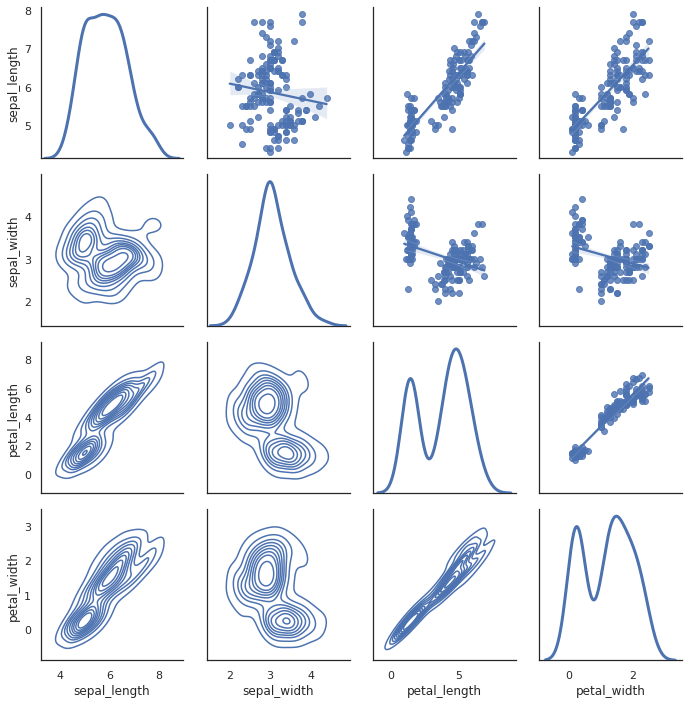

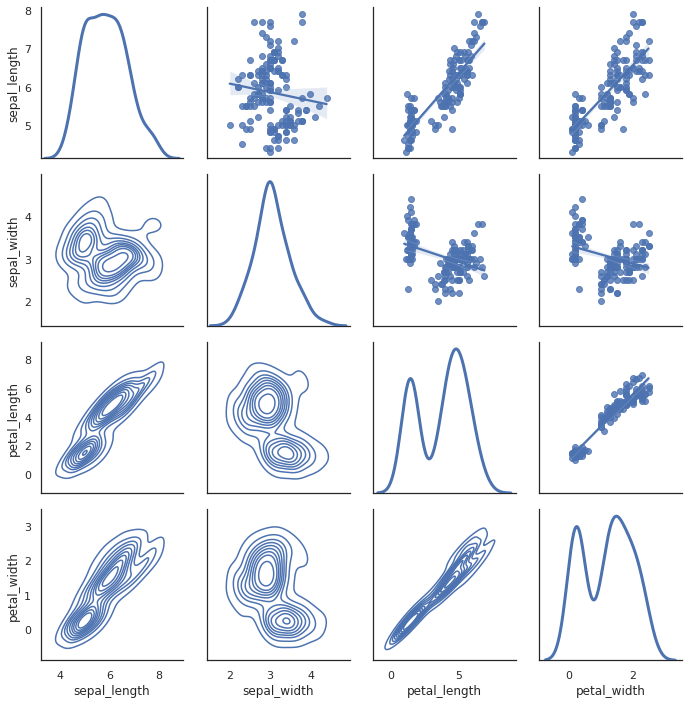

In [0]:
import seaborn as sns
sns.set(style="white")

df = sns.load_dataset("iris")
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3)

g.map_upper(sns.regplot)

display(g.fig)

### Example: Population versus Price

In [0]:
data = spark.read.csv("/databricks-datasets/samples/population-vs-price/data_geo.csv", header="true", inferSchema="true") 
data.take(10)

Out[29]: [Row(2014 rank=101, City='Birmingham', State='Alabama', State Code='AL', 2014 Population estimate=212247, 2015 median sales price=162.9),
 Row(2014 rank=125, City='Huntsville', State='Alabama', State Code='AL', 2014 Population estimate=188226, 2015 median sales price=157.7),
 Row(2014 rank=122, City='Mobile', State='Alabama', State Code='AL', 2014 Population estimate=194675, 2015 median sales price=122.5),
 Row(2014 rank=114, City='Montgomery', State='Alabama', State Code='AL', 2014 Population estimate=200481, 2015 median sales price=129.0),
 Row(2014 rank=64, City='Anchorage[19]', State='Alaska', State Code='AK', 2014 Population estimate=301010, 2015 median sales price=None),
 Row(2014 rank=78, City='Chandler', State='Arizona', State Code='AZ', 2014 Population estimate=254276, 2015 median sales price=None),
 Row(2014 rank=86, City='Gilbert[20]', State='Arizona', State Code='AZ', 2014 Population estimate=239277, 2015 median sales price=None),
 Row(2014 rank=88, City='Glendale'

In [0]:
%python
display(data)

2014 rank City State State Code 2014 Population estimate 2015 median sales price 101 Birmingham Alabama AL 212247 162.9 125 Huntsville Alabama AL 188226 157.7 122 Mobile Alabama AL 194675 122.5 114 Montgomery Alabama AL 200481 129.0 64 Anchorage[19] Alaska AK 301010 null 78 Chandler Arizona AZ 254276 null 86 Gilbert[20] Arizona AZ 239277 null 88 Glendale Arizona AZ 237517 null 38 Mesa Arizona AZ 464704 null 148 Peoria Arizona AZ 166934 null 6 Phoenix Arizona AZ 1537058 206.1 95 Scottsdale Arizona AZ 230512 null 215 Surprise Arizona AZ 126275 null 142 Tempe Arizona AZ 172816 null 33 Tucson Arizona AZ 527972 178.1 119 Little Rock Arkansas AR 197706 131.8 56 Anaheim California CA 346997 685.7 261 Antioch California CA 108930 null 52 Bakersfield California CA 368759 null 227 Berkeley California CA 118853 null 276 Burbank California CA 105368 null 245 Carlsbad California CA 112299 null 75 Chula Vista California CA 260988 null 291 Clovis California CA 102189 null 212 Concord California CA 127522 null 153 Corona California CA 161486 null 243 Costa Mesa California CA 112784 null 274 Daly City California CA 106094 null 240 Downey California CA 114172 null 285 El Cajon California CA 103091 null 234 El Monte California CA 116631 null 151 Elk Grove California CA 163553 null 167 Escondido California CA 150243 null 250 Fairfield California CA 111125 null 108 Fontana California CA 204950 null 97 Fremont California CA 228758 null 34 Fresno California CA 515986 null 186 Fullerton California CA 139677 null 136 Garden Grove California CA 175078 null 116 Glendale California CA 200167 null 161 Hayward California CA 154612 null 112 Huntington Beach California CA 200809 null 248 Inglewood California CA 111905 null 82 Irvine California CA 248531 null 154 Lancaster California CA 161043 null 36 Long Beach California CA 473577 null 2 Los Angeles California CA 3928864 434.7 104 Modesto California CA 209286 null 110 Moreno Valley California CA 202976 null 268 Murrieta California CA 108368 null 270 Norwalk California CA 107096 null 45 Oakland California CA 413775 null 137 Oceanside California CA 174558 null 146 Ontario California CA 169089 null 185 Orange California CA 139812 null 106 Oxnard California CA 205437 null 156 Palmdale California CA 158279 null 184 Pasadena California CA 140881 null 165 Pomona California CA 153350 null 138 Rancho Cucamonga California CA 174305 null 288 Rialto California CA 102741 null 265 Richmond California CA 108565 null 59 Riverside California CA 319504 281.0 205 Roseville California CA 128615 null 35 Sacramento California CA 485199 275.8 158 Salinas California CA 156677 null 100 San Bernardino California CA 215213 null 8 San Diego California CA 1381069 510.3 13 San Francisco[10] California CA 852469 748.3 10 San Jose California CA 1015785 900.0 286 San Mateo California CA 102893 null 57 Santa Ana California CA 334909 null 219 Santa Clara California CA 122192 null 133 Santa Clarita California CA 181557 null 284 Santa Maria California CA 103410 null 139 Santa Rosa California CA 174170 null 214 Simi Valley California CA 126871 null 63 Stockton California CA 302389 null 168 Sunnyvale California CA 149980 null 259 Temecula California CA 109428 null 201 Thousand Oaks California CA 129342 null 172 Torrance California CA 148495 null 224 Vallejo California CA 120228 null 258 Ventura[29] California CA 109484 null 220 Victorville California CA 121901 null 202 Visalia California CA 129281 null 266 West Covina California CA 108455 null 242 Arvada Colorado CO 113574 null 54 Aurora Colorado CO 353108 null 278 Boulder Colorado CO 105112 442.2 269 Centennial Colorado CO 107201 null 42 Colorado Springs Colorado CO 445830 220.1 21 Denver[12] Colorado CO 663862 338.1 159 Fort Collins Colorado CO 156480 null 169 Lakewood Colorado CO 149643 null 267 Pueblo Colorado CO 108423 null 197 Thornton Colorado CO 130307 null 247 Westminster Colorado CO 112090 null 175 Bridgeport Connecticut CT 147612 342.7 218 Hartford Connecticut CT 124705 202.6 198 New 

In [0]:
# Register table so it is accessible via SQL Context
data.createOrReplaceTempView("data_geo")

#### Hover over the state for 2015 Median Home Prices

In [0]:
%sql
select `State Code`, `2015 median sales price` 
from data_geo

State Code 2015 median sales price AL 162.9 AL 157.7 AL 122.5 AL 129.0 AK null AZ null AZ null AZ null AZ null AZ null AZ 206.1 AZ null AZ null AZ null AZ 178.1 AR 131.8 CA 685.7 CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA 434.7 CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA 281.0 CA null CA 275.8 CA null CA null CA 510.3 CA 748.3 CA 900.0 CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CO null CO null CO 442.2 CO null CO 220.1 CO 338.1 CO null CO null CO null CO null CO null CT 342.7 CT 202.6 CT 205.1 CT null CT null DC 367.8 FL 208.0 FL null FL null FL null FL 169.9 FL null FL null FL 182.5 FL 136.0 FL 269.1 FL null FL null FL null FL 145.0 FL null FL null FL 172.0 FL null FL 170.5 FL 156.0 FL null GA null GA 158.0 GA null GA null GA null GA null GA null HI 699.3 ID 178.7 IL null IL 192.5 IL null IL null IL null IL 105.2 IL 78.6 IL 115.2 IN null IN 106.3 IN 139.2 IA 156.9 IA 109.4 IA null KS null KS null KS null KS 105.3 KS 126.0 KY 141.2 KY 141.1 LA 177.2 LA null LA null LA 151.6 MD 223.1 MA 374.6 MA null MA null MA 183.9 MA 226.9 MI null MI null MI null MI 114.6 MI null MI null MN 209.4 MN null MN null MS 154.1 MO null MO null MO 153.0 MO 116.5 MO null MT null NE 150.2 NE 148.1 NV null NV 205.9 NV null NV 268.7 NH 237.4 NJ null NJ null NJ 350.8 NJ null NM 172.2 NM null NY 117.3 NY 388.6 NY 118.9 NY 118.3 NY null NC null NC 197.2 NC 196.9 NC 145.0 NC 138.3 NC null NC 218.9 NC 197.5 NC 138.6 ND 180.0 OH 95.4 OH 135.0 OH 105.9 OH 149.9 OH 107.2 OH 83.8 OK null OK null OK null OK 145.1 OR 211.3 OR null OR 289.4 OR 193.9 PA 162.7 PA 204.9 PA null RI 233.3 SC null SC null SC null SD 159.5 TN 143.6 TN null TN 149.2 TN 132.1 TN null TN 186.4 TX 145.7 TX 144.4 TX null TX 249.1 TX 133.3 TX null TX null TX null TX 172.9 TX 192.5 TX null TX 138.4 TX null TX null TX null TX null TX 200.3 TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX 184.7 TX null TX null TX null UT null UT 243.3 UT null UT null VA null VA null VA null VA null VA null VA 212.5 VA 190.0 WA null WA null WA null WA 352.4 WA 180.2 WA null WA null WI null WI 226.2 WI 195.4

### Top 10 Cities by 2015 Median Sales Price

In [0]:
%sql
select City, `2014 Population estimate`/1000 as `2014 Population Estimate (1000s)`, `2015 median sales price` as `2015 Median Sales Price (1000s)` 
from data_geo 
order by `2015 median sales price` desc limit 10;

City 2014 Population Estimate (1000s) 2015 Median Sales Price (1000s) San Jose 1015.785 900.0 San Francisco[10] 852.469 748.3 Honolulu[2] 350.399 699.3 Anaheim 346.997 685.7 San Diego 1381.069 510.3 Boulder 105.112 442.2 Los Angeles 3928.864 434.7 New York[6] 8491.079 388.6 Boston 655.884 374.6 Washington[13] 658.893 367.8

### 2014 Population Estimates in Washington State

In [0]:
%sql
select City, `2014 Population estimate` 
from data_geo 
where `State Code` = 'WA';

City 2014 Population estimate Bellevue 136426 Everett 106736 Kent 125560 Seattle 668342 Spokane 212052 Tacoma 205159 Vancouver 169294

### 2015 Median Sales Price Box Plot

Box plot shows means + variation of prices.

In [0]:
%sql
select `State Code`, `2015 median sales price` 
from data_geo 
order by `2015 median sales price` desc;

State Code 2015 median sales price CA 900.0 CA 748.3 HI 699.3 CA 685.7 CA 510.3 CO 442.2 CA 434.7 NY 388.6 MA 374.6 DC 367.8 WA 352.4 NJ 350.8 CT 342.7 CO 338.1 OR 289.4 CA 281.0 CA 275.8 FL 269.1 NV 268.7 TX 249.1 UT 243.3 NH 237.4 RI 233.3 MA 226.9 WI 226.2 MD 223.1 CO 220.1 NC 218.9 VA 212.5 OR 211.3 MN 209.4 FL 208.0 AZ 206.1 NV 205.9 CT 205.1 PA 204.9 CT 202.6 TX 200.3 NC 197.5 NC 197.2 NC 196.9 WI 195.4 OR 193.9 IL 192.5 TX 192.5 VA 190.0 TN 186.4 TX 184.7 MA 183.9 FL 182.5 WA 180.2 ND 180.0 ID 178.7 AZ 178.1 LA 177.2 TX 172.9 NM 172.2 FL 172.0 FL 170.5 FL 169.9 AL 162.9 PA 162.7 SD 159.5 GA 158.0 AL 157.7 IA 156.9 FL 156.0 MS 154.1 MO 153.0 LA 151.6 NE 150.2 OH 149.9 TN 149.2 NE 148.1 TX 145.7 OK 145.1 FL 145.0 NC 145.0 TX 144.4 TN 143.6 KY 141.2 KY 141.1 IN 139.2 NC 138.6 TX 138.4 NC 138.3 FL 136.0 OH 135.0 TX 133.3 TN 132.1 AR 131.8 AL 129.0 KS 126.0 AL 122.5 NY 118.9 NY 118.3 NY 117.3 MO 116.5 IL 115.2 MI 114.6 IA 109.4 OH 107.2 IN 106.3 OH 105.9 KS 105.3 IL 105.2 OH 95.4 OH 83.8 IL 78.6 AK null AZ null AZ null AZ null AZ null AZ null AZ null AZ null AZ null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CO null CO null CO null CO null CO null CO null CO null CO null CT null CT null FL null FL null FL null FL null FL null FL null FL null FL null FL null FL null FL null FL null GA null GA null GA null GA null GA null GA null IL null IL null IL null IL null IN null IA null KS null KS null KS null LA null LA null MA null MA null MI null MI null MI null MI null MI null MN null MN null MO null MO null MO null MT null NV null NV null NJ null NJ null NJ null NM null NY null NC null NC null OK null OK null OK null OR null PA null SC null SC null SC null TN null TN null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null UT null UT null UT null VA null VA null VA null VA null VA null WA null WA null WA null WA null WA null WI null

### 2015 Median Sales Price by State Histogram

In [0]:
%sql
select `State Code`, `2015 median sales price` 
from data_geo 
order by `2015 median sales price` desc;

State Code 2015 median sales price CA 900.0 CA 748.3 HI 699.3 CA 685.7 CA 510.3 CO 442.2 CA 434.7 NY 388.6 MA 374.6 DC 367.8 WA 352.4 NJ 350.8 CT 342.7 CO 338.1 OR 289.4 CA 281.0 CA 275.8 FL 269.1 NV 268.7 TX 249.1 UT 243.3 NH 237.4 RI 233.3 MA 226.9 WI 226.2 MD 223.1 CO 220.1 NC 218.9 VA 212.5 OR 211.3 MN 209.4 FL 208.0 AZ 206.1 NV 205.9 CT 205.1 PA 204.9 CT 202.6 TX 200.3 NC 197.5 NC 197.2 NC 196.9 WI 195.4 OR 193.9 IL 192.5 TX 192.5 VA 190.0 TN 186.4 TX 184.7 MA 183.9 FL 182.5 WA 180.2 ND 180.0 ID 178.7 AZ 178.1 LA 177.2 TX 172.9 NM 172.2 FL 172.0 FL 170.5 FL 169.9 AL 162.9 PA 162.7 SD 159.5 GA 158.0 AL 157.7 IA 156.9 FL 156.0 MS 154.1 MO 153.0 LA 151.6 NE 150.2 OH 149.9 TN 149.2 NE 148.1 TX 145.7 OK 145.1 FL 145.0 NC 145.0 TX 144.4 TN 143.6 KY 141.2 KY 141.1 IN 139.2 NC 138.6 TX 138.4 NC 138.3 FL 136.0 OH 135.0 TX 133.3 TN 132.1 AR 131.8 AL 129.0 KS 126.0 AL 122.5 NY 118.9 NY 118.3 NY 117.3 MO 116.5 IL 115.2 MI 114.6 IA 109.4 OH 107.2 IN 106.3 OH 105.9 KS 105.3 IL 105.2 OH 95.4 OH 83.8 IL 78.6 AK null AZ null AZ null AZ null AZ null AZ null AZ null AZ null AZ null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CA null CO null CO null CO null CO null CO null CO null CO null CO null CT null CT null FL null FL null FL null FL null FL null FL null FL null FL null FL null FL null FL null FL null GA null GA null GA null GA null GA null GA null IL null IL null IL null IL null IN null IA null KS null KS null KS null LA null LA null MA null MA null MI null MI null MI null MI null MI null MN null MN null MO null MO null MO null MT null NV null NV null NJ null NJ null NJ null NM null NY null NC null NC null OK null OK null OK null OR null PA null SC null SC null SC null TN null TN null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null TX null UT null UT null UT null VA null VA null VA null VA null VA null WA null WA null WA null WA null WA null WI null

### 2015 Median Sales Price by State Quantile Plot >= $ 300,000

Quantile plots help describe distributions (in this case, the distribution of sales prices across cities) and highlight aspects such as skewed distributions.

In [0]:
%sql
select `State Code`, `2015 median sales price` 
from data_geo 
where `2015 median sales price` >= 300;

State Code 2015 median sales price CA 685.7 CA 434.7 CA 510.3 CA 748.3 CA 900.0 CO 442.2 CO 338.1 CT 342.7 DC 367.8 HI 699.3 MA 374.6 NJ 350.8 NY 388.6 WA 352.4

### Cities with 2015 Median Sales Price >= $ 300,000

In [0]:
%sql
select `City`, `State Code`, `2015 median sales price` 
from data_geo 
where `2015 median sales price` >= 300 
limit 20;

City State Code 2015 median sales price Anaheim CA 685.7 Los Angeles CA 434.7 San Diego CA 510.3 San Francisco[10] CA 748.3 San Jose CA 900.0 Boulder CO 442.2 Denver[12] CO 338.1 Bridgeport CT 342.7 Washington[13] DC 367.8 Honolulu[2] HI 699.3 Boston MA 374.6 Newark NJ 350.8 New York[6] NY 388.6 Seattle WA 352.4

### 2015 Median Sales Price Q-Q Plot

Q-Q plots provide yet another view of distributions.  See [Wikipedia on Q-Q Plots](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) for more background.

In [0]:
%sql
select `State Code`, 
   case when `2015 median sales price` >= 300  then '>=300K' 
        when `2015 median sales price` < 300 then '< 300K' 
   end as `Category`, `2015 median sales price` 
from data_geo 
order by `2015 median sales price` desc;

State Code Category 2015 median sales price CA >=300K 900.0 CA >=300K 748.3 HI >=300K 699.3 CA >=300K 685.7 CA >=300K 510.3 CO >=300K 442.2 CA >=300K 434.7 NY >=300K 388.6 MA >=300K 374.6 DC >=300K 367.8 WA >=300K 352.4 NJ >=300K 350.8 CT >=300K 342.7 CO >=300K 338.1 OR < 300K 289.4 CA < 300K 281.0 CA < 300K 275.8 FL < 300K 269.1 NV < 300K 268.7 TX < 300K 249.1 UT < 300K 243.3 NH < 300K 237.4 RI < 300K 233.3 MA < 300K 226.9 WI < 300K 226.2 MD < 300K 223.1 CO < 300K 220.1 NC < 300K 218.9 VA < 300K 212.5 OR < 300K 211.3 MN < 300K 209.4 FL < 300K 208.0 AZ < 300K 206.1 NV < 300K 205.9 CT < 300K 205.1 PA < 300K 204.9 CT < 300K 202.6 TX < 300K 200.3 NC < 300K 197.5 NC < 300K 197.2 NC < 300K 196.9 WI < 300K 195.4 OR < 300K 193.9 IL < 300K 192.5 TX < 300K 192.5 VA < 300K 190.0 TN < 300K 186.4 TX < 300K 184.7 MA < 300K 183.9 FL < 300K 182.5 WA < 300K 180.2 ND < 300K 180.0 ID < 300K 178.7 AZ < 300K 178.1 LA < 300K 177.2 TX < 300K 172.9 NM < 300K 172.2 FL < 300K 172.0 FL < 300K 170.5 FL < 300K 169.9 AL < 300K 162.9 PA < 300K 162.7 SD < 300K 159.5 GA < 300K 158.0 AL < 300K 157.7 IA < 300K 156.9 FL < 300K 156.0 MS < 300K 154.1 MO < 300K 153.0 LA < 300K 151.6 NE < 300K 150.2 OH < 300K 149.9 TN < 300K 149.2 NE < 300K 148.1 TX < 300K 145.7 OK < 300K 145.1 FL < 300K 145.0 NC < 300K 145.0 TX < 300K 144.4 TN < 300K 143.6 KY < 300K 141.2 KY < 300K 141.1 IN < 300K 139.2 NC < 300K 138.6 TX < 300K 138.4 NC < 300K 138.3 FL < 300K 136.0 OH < 300K 135.0 TX < 300K 133.3 TN < 300K 132.1 AR < 300K 131.8 AL < 300K 129.0 KS < 300K 126.0 AL < 300K 122.5 NY < 300K 118.9 NY < 300K 118.3 NY < 300K 117.3 MO < 300K 116.5 IL < 300K 115.2 MI < 300K 114.6 IA < 300K 109.4 OH < 300K 107.2 IN < 300K 106.3 OH < 300K 105.9 KS < 300K 105.3 IL < 300K 105.2 OH < 300K 95.4 OH < 300K 83.8 IL < 300K 78.6 AK null null AZ null null AZ null null AZ null null AZ null null AZ null null AZ null null AZ null null AZ null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CA null null CO null null CO null null CO null null CO null null CO null null CO null null CO null null CO null null CT null null CT null null FL null null FL null null FL null null FL null null FL null null FL null null FL null null FL null null FL null null FL null null FL null null FL null null GA null null GA null null GA null null GA null null GA null null GA null null IL null null IL null null IL null null IL null null IN null null IA null null KS null null KS null null KS null null LA null null LA null null MA null null MA null null MI null null MI null null MI null null MI null null MI null null MN null null MN null null MO null null MO null null MO null null MT null null NV null null NV null null NJ null null NJ null null NJ null null NM null null NY null null NC null null NC null null OK null null OK null null OK null null OR null null PA null null SC null null SC null null SC null null TN null null TN null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX null null TX nu